# DSE 10 Homework 4 - Due 02/05/2021 9:00am

## Instructions
* Please upload all work to gradescope by the due date - **late work will not be graded**
    * You should submit a single ipynb file containing all your code and output (plots, numeric values, etc...)
    * Important: **name your ipynb file according to the following convention**: `<lastname>_<firstname>.ipynb` - example: (`thomas_anthony.ipynb`)
    * Please organize your notebook into sections by problem
    * Use print statements to clearly indicate which question you are ansering
        * Good: `print("Problem 4 (e): {}".format(np.pi))`
        * Good: `print("The value of pi is: {}".format(np.pi))`
        * Bad:  `print(np.pi)`
        * Bad:  `np.pi`
    * Use relative paths to load data:
        * Good: `loadmnist("train-images-idx3-ubyte", "train-labels-idx1-ubyte")`
        * Bad: `loadmnist("/home/anthony/class/DSE10/train-images-idx3-ubyte", ...)`
* Collaboration is encouraged, but all submissions should be in your own writing/code and written with your own understanding
* Your code must run and be able to reproduce your answers
* Unless stated otherwise in the assignemnt, your code should use only basic low-level NumPy/SciPy linear algebra and satistics commands (e.g. do not use built in estimation tools or anything from SciKitLearn). When in doubt, ask for clarification on Canvas.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import gzip
import sys
import os
import copy
import numpy as np
import pandas as pd
import pickle
import string
import operator
import bz2
import random
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.neighbors import BallTree
from sklearn import metrics
from sklearn.preprocessing import scale
from pylab import rcParams
from struct import unpack
from scipy.stats import multivariate_normal

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Worksheet 9 Problem 3

#### Text classification using multinomial Naive Bayes.

#### (a) For this problem, you’ll be using the 20 Newsgroups data set. There are several versions of it on the web. You should download “20news-bydate.tar.gz” from
                               http://qwone.com/~jason/20Newsgroups/
#### Unpack it and look through the directories at some of the files. Overall, there are roughly 19,000 documents, each from one of 20 newsgroups. The label of a document is the identity of its newsgroup. The documents are divided into a training set and a test set.

In [2]:
def download(filename, source = 'http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)
    
def load_data(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset = 16)
    return data / np.float32(256)

In [3]:
newsgroup_data = load_data('20news-bydate.tar.gz')

#### (b) The same website has a processed version of the data, “20news-bydate-matlab.tgz”, that is par- ticularly convenient to use. Download this and also the file “vocabulary.txt”. Look at the first training document in the processed set and the corresponding original text document to under- stand the relation between the two.

In [4]:
train_data = pd.read_csv('20news-bydate 2/matlab/train.data', header = None, sep =' ')
train_label = pd.read_csv('20news-bydate 2/matlab/train.label', header = None, sep = ' ')
train_map = pd.read_csv('20news-bydate 2/matlab/train.map', header = None, sep = ' ')
test_data = pd.read_csv('20news-bydate 2/matlab/test.data', header = None, sep =' ')
test_label = pd.read_csv('20news-bydate 2/matlab/test.label', header = None, sep =' ')
test_map = pd.read_csv('20news-bydate 2/matlab/test.map', header = None, sep = ' ')
vocabulary_data = pd.read_csv('vocabulary.txt', names = ['word'], header = None, sep =' ')

#### (c) The words in the documents constitute an overall vocabulary V of size 61188. Build a multinomial Naive Bayes model using the training data. For each of the 20 classes j = 1, 2, . . . , 20, you must have the following:

    • pij, the fraction of documents that belong to that class; and
    • Pj, a probability distribution over V that models the documents of that class.
    
#### In order to fit Pj, imagine that all the documents of class j are strung together. For each word w 2 V , let Pjw be the fraction of this concatenated document occupied by w. Well, almost: you will need to do smoothing (just add one to the count of how often w occurs).

In [5]:
x_train_data, y_train_label, x_test_data, y_test_label = train_data, train_label, test_data, test_label

In [6]:
x_train_data.columns = ['docIdx', 'wordIdx', 'count']
y_train_label['docIdx'] = range(1, len(y_train_label) + 1)
y_train_label.columns = ['class', 'docIdx']
x_train_data = x_train_data.merge(y_train_label, how = 'left', on = 'docIdx') 

In [7]:
x_test_data.columns = ['docIdx', 'wordIdx', 'count']
y_test_label['docIdx'] = range(1, len(y_test_label) + 1)
y_test_label.columns = ['class', 'docIdx']
x_test_data = x_test_data.merge(y_test_label, how = 'left',on = 'docIdx') 

In [8]:
# calculate pi
pi = np.zeros(20)
for j in range(20):
    pi[j] = np.sum(y_train_label.iloc[:,0] == j + 1)/len(y_train_label)
    
print('Fraction of documents in each class:\n', pi)

Fraction of documents in each class:
 [0.04259473 0.05155737 0.05075872 0.0520898  0.05102494 0.0525335
 0.05164611 0.0525335  0.05288846 0.05271098 0.05306593 0.05271098
 0.05244476 0.05271098 0.05262224 0.05315467 0.04836277 0.05004881
 0.0411749  0.03336587]


In [9]:
# calculate p
total = vocabulary_data.shape[0]
p = np.zeros((20,total ))

for j in range(20):
    tmp = x_train_data[x_train_data['class'] == j + 1]
    p[j,:] = 1   
    for i in range(tmp.shape[0]):  
        wdidx = tmp['wordIdx'].iloc[i]
        count = tmp['count'].iloc[i]
        p[j, wdidx - 1] += count
    p[j,:] = p[j,:]/np.sum(p[j,:])
    
print('Probability Distribution:\n', p)

Probability Distribution:
 [[6.66666667e-05 3.04761905e-04 1.31428571e-03 ... 4.76190476e-06
  4.76190476e-06 4.76190476e-06]
 [3.55589754e-04 3.49760414e-04 5.82934024e-06 ... 5.82934024e-06
  5.82934024e-06 5.82934024e-06]
 [7.89707479e-05 4.60662696e-04 6.58089566e-06 ... 6.58089566e-06
  6.58089566e-06 6.58089566e-06]
 ...
 [3.48108977e-05 4.90517195e-04 3.16462706e-06 ... 3.16462706e-06
  3.16462706e-06 3.16462706e-06]
 [4.03854386e-06 1.61541755e-04 4.03854386e-06 ... 4.03854386e-06
  4.03854386e-06 4.03854386e-06]
 [5.54680393e-06 2.55152981e-04 5.54680393e-05 ... 5.54680393e-06
  5.54680393e-06 5.54680393e-06]]


#### (d) Write a routine that uses this naive Bayes model to classify a new document. To avoid underflow, work with logs rather than multiplying together probabilities.

In [10]:
def decision(x_test_data, pi, p):
    wdidx = x_test_data['wordIdx']
    prob = [np.log(pi[j]) + np.sum(x_test_data['count'] * np.log(p[j,wdidx - 1 ])) for j in range(20)]
    pred = np.argmax(prob)
        
    return pred , prob

#### (e) Evaluate the performance of your model on the test data. What error rate do you achieve?

In [11]:
result = []
for i in range(y_test_label.shape[0]):
    x_test = x_test_data.loc[x_test_data['docIdx'] == i + 1,:]
    pred, prob = decision(x_test, pi, p)
    result.append(pred + 1 != y_test_label['class'].iloc[i])
    
# calculate the error rate of naive Bayes model
error_rate = np.mean(result) * 100
print('Error rate of naive Bayes model is:\n{}%'.format(error_rate))

Error rate of naive Bayes model is:
21.892071952031976%


Conclusion: We have evaluated naive Bayes models on the test data, and it turns out that this model performs a good accurate, whose error rate is 20.3%.

# Worksheet 9 Problem 4

4. Handwritten digit recognition using a Gaussian generative model. In class, we mentioned the MNIST data set of handwritten digits. You can obtain it from:

    http://yann.lecun.com/exdb/mnist/index.html
    
 In this problem, you will build a classifier for this data, by modeling each class as a multivariate (784-dimensional) Gaussian.

#### (a) Upon downloading the data, you should have two training files (one with images, one with labels) and two test files. Unzip them. In order to load the data into Python you will find the following code helpful:

    http://cseweb.ucsd.edu/~dasgupta/dse210/loader.py
    
#### For instance, to load in the training data, you can use:

    x,y = loadmnist(’train-images-idx3-ubyte’, ’train-labels-idx1-ubyte’)
    
#### This will set x to a 60000 x 784 array where each row corresponds to an image, and y to a length-60000 array where each entry is a label (0-9). There is also a routine to display images: use displaychar(x[0]) to show the first data point, for instance.

In [12]:
def download(filename, source = 'http://yann.lecun.com/exdb/mnist/index.html'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)
    
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset = 16)
    data = data.reshape(-1,784)
    return data / np.float32(256)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset = 8)
    return data

def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

In [13]:
# Load the training data set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

print('Shape of the train data:\n', train_data.shape)
print('\nShape of the train labels:\n', train_labels.shape)

Shape of the train data:
 (60000, 784)

Shape of the train labels:
 (60000,)


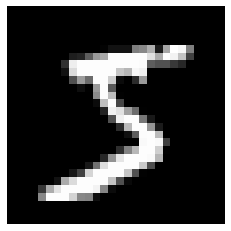

In [14]:
# Display the first data point
displaychar(train_data[0])

#### (b) Split the training set into two pieces – a training set of size 50000, and a separate validation set of size 10000. Also load in the test data.

In [15]:
x, y = train_data, train_labels

# randomly select 50000 data from data set as training data set.
random.seed(10)
sel = random.sample(range (0, x.shape[0]), 50000 )
x_train_data, y_train_data = train_data[sel,], train_labels[sel,]

print('Shape of x_train_data:\n', x_train_data.shape)
print('\nShape of y_train_data:\n', y_train_data.shape)

Shape of x_train_data:
 (50000, 784)

Shape of y_train_data:
 (50000,)


In [16]:
# get the remaining data as validation data set.
remain = np.setdiff1d(range(0, x.shape[0]), sel)
x_validation, y_validation = train_data[remain,], train_labels[remain,]

print('Shape of x_validation:\n', x_validation.shape)
print('\nShape of y_validation:\n', y_validation.shape)

Shape of x_validation:
 (10000, 784)

Shape of y_validation:
 (10000,)


In [17]:
# Load the testing data set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

print('Shape of the test data:\n', test_data.shape)
print('\nShape of the test labels:\n', test_labels.shape)

Shape of the test data:
 (10000, 784)

Shape of the test labels:
 (10000,)


#### (c) Now fit a Gaussian generative model to the training data of 50000 points.

• Determine the class probabilities.

• Fit a Gaussian to each digit, by finding the mean and the covariance of the corresponding data points.

In [18]:
# create a multivariabte Gaussian model

def MultivariateGaussian(x, y):
    #labels 1,2,...,k
    k = 10  
    
    #number of features
    d = (x.shape)[1]  
    
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    
    for label in range(10):
        indices = np.where(y == label)
        indices = indices[0]
        mu[label] = np.mean(x[indices,:], axis=0)
        sigma[label] = np.cov(x[indices,:], rowvar=0, bias=1)
        pi[label] = float(len(indices))/float(len(y))
    return mu, sigma, pi

In [19]:
# get the mu, sigma, and pi
mu, sigma, pi = MultivariateGaussian(x_train_data, y_train_data)

In [20]:
print('Class probabilities:\n', pi)

Class probabilities:
 [0.0989  0.1129  0.09792 0.10202 0.09642 0.091   0.09882 0.10514 0.0978
 0.09908]


In [21]:
print('Mean of the corresponding data points:\n ', mu)

Mean of the corresponding data points:
  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
print('Covariance of the corresponding data points:\n ', sigma)

Covariance of the corresponding data points:
  [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0

#### (d) One last step is needed: it is important to smooth the covariance matrices, and the usual way to do this is to add in cI, where c is some constant and I is the identity matrix. What value of c is right? Use the validation set to help you choose. That is, choose the value of c for which the resulting classifier makes the fewest mistakes on the validation set. What value of c did you get?

In [23]:
# classify funtion using Bayes' rule

def decision(x, pi, mu, sigma): 
    prob = np.zeros((10, x.shape[0]))
    
    for i in range (0,10):
        prob[i,:] = pi[i]* multivariate_normal.pdf(x, mean = mu[i,:], cov = sigma[i,:,:])                                             
        #if the sigma matrix cannot be inversed, we need to add a np.eye() to avoid singular matrix error.
        #since we will smooth in step (d), so I didn't use np.eye() here.
        #prob[i,:] = pi[i]* multivariate_normal.pdf(x, mean = mu[i,:], cov = sigma[i,:,:] + np.eye(sigma.shape[1],sigma.shape[2]))

    pred = np.argmax(prob, axis = 0)

    return pred, prob

In [24]:
# set c as a constant and I as the identity matix
# randomly give c a number
c = 0.1
iden = np.zeros((10,784,784))

for i in range (0,10) :
    iden[i,:,:] = np.diag([1] * 784) 

# smooth the covariance matrix
decision(x_validation[:5,], pi, mu, sigma + c * iden)

(array([0, 9, 4, 0, 9]),
 array([[3.52395032e+36, 9.94963706e+02, 4.04319827e-42, 1.73069617e+31,
         2.60846830e+03],
        [2.76205313e-59, 3.89010386e+23, 1.37779283e-87, 1.71922354e-70,
         5.36199288e+13],
        [1.67822220e+09, 2.20521407e+12, 3.34169997e-05, 1.33258778e+04,
         6.56761242e+10],
        [5.52541293e+03, 1.30537050e+18, 3.96725820e-08, 6.44940176e+04,
         1.77372353e+14],
        [2.12330838e-18, 1.03923436e+24, 1.47574376e+20, 2.85214873e-19,
         1.13417968e+20],
        [4.32712370e+03, 5.06260109e+15, 1.08791462e-21, 4.09520025e+06,
         8.53140112e+08],
        [7.30100850e+07, 4.61689670e+05, 1.08491729e-28, 2.60239295e+06,
         3.10196619e-05],
        [1.51033108e-17, 3.29536606e+32, 2.50752743e-12, 1.05837175e-27,
         1.41461342e+35],
        [1.00110917e-06, 1.36214676e+24, 5.55170895e-10, 6.06793379e-15,
         1.18698631e+20],
        [1.17818041e-04, 4.03108896e+38, 1.23801240e-04, 1.00516671e-12,
         1.

In [25]:
c_grid = np.linspace(0.01, 0.3, num=20 )
validation_error =[]

for c in c_grid:
    pred = decision(x_validation, pi, mu, sigma + c * iden)[0]
    validation_error.append(1 - np.mean(pred == y_validation))

The optimal of c is:
 0.048799999999999955


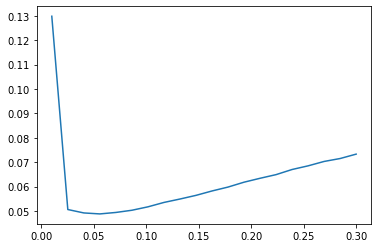

In [26]:
# smaller erorr is desired
plt.plot(c_grid,validation_error)

# find the optimal c value
c_optim = c_grid[np.argmin(validation_error)]

print('The optimal of c is:\n', np.min(validation_error))

#### (e) Turn in an iPython notebook that includes:

    • All your code.
    
    • Error rate on the MNIST test set.
    
    • Out of the misclassified test digits, pick five at random and display them. For each instance, list the posterior probabilities Pr(y|x) of each of the ten classes.

In [27]:
# calculate the error rate on the MNIST test set.
accuracy = np.mean(decision(test_data, pi, mu, sigma + c_optim * iden)[0] == test_labels)
error_rate = (1 - accuracy)*100

print('Error rate on the MNIST test set:\n{}%'.format(error_rate))

Error rate on the MNIST test set:
4.3799999999999955%


In [28]:
pred, prob = decision(test_data,pi, mu, sigma + c_optim * iden)

posterior probabilities:
 [1.39773549e-28 3.29542606e-31 9.44407064e-07 8.93100210e-11
 5.10498694e-32 2.15188108e-35 1.76340732e-59 3.71674998e-20
 9.99999056e-01 4.60969151e-25]

predicted digit: 8

true digit: 2


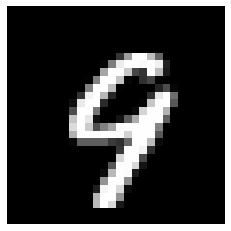

posterior probabilities:
 [9.90840610e-001 1.96922947e-134 5.59213076e-006 2.73862179e-015
 9.26492386e-015 8.29549696e-003 2.31647883e-010 2.36242297e-026
 1.17461319e-034 8.58301070e-004]

predicted digit: 0

true digit: 9


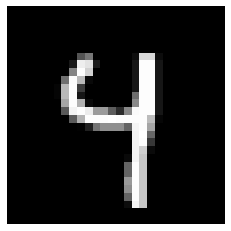

posterior probabilities:
 [1.33288214e-022 4.78235805e-141 1.39248990e-009 9.99999999e-001
 1.79715520e-067 4.52804023e-026 5.12737030e-081 1.69816726e-043
 1.51046950e-021 3.78681257e-032]

predicted digit: 3

true digit: 9


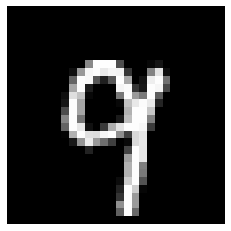

posterior probabilities:
 [7.24531355e-001 8.06604028e-122 2.07758767e-013 2.68522993e-001
 5.10092467e-055 1.94953938e-007 3.58494474e-014 8.39106303e-081
 6.94545720e-003 1.19623255e-040]

predicted digit: 0

true digit: 8


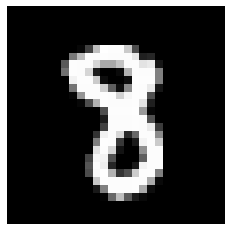

posterior probabilities:
 [3.60704806e-23 4.73306638e-08 1.62911845e-22 3.03170718e-25
 1.07755734e-29 4.39101476e-22 9.99999953e-01 5.30893474e-48
 1.17243012e-17 1.22402935e-40]

predicted digit: 6

true digit: 1


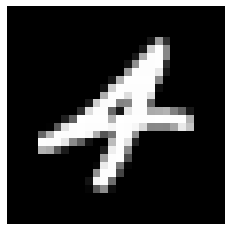

In [29]:
mis = np.where(pred != test_labels)[0]
random.seed(14)

for i in random.sample(range(0,len(mis)),5):
    print('posterior probabilities:\n', prob[:,mis[i]]/np.sum(prob[:,mis[i]]))
    #print(np.where(np.argmax(prob[:,mis[i]]/np.sum(prob[:,mis[i]]))))
    print('\npredicted digit:', np.argmax(prob[:,mis[i]]/np.sum(prob[:,mis[i]])))
    print('\ntrue digit:', test_labels[mis[i]])
    displaychar(train_data[mis[i]])

# Worksheet 10 Problem 2

For this problem, we’ll be using the animals with attributes data set. Go to 

    http://attributes.kyb.tuebingen.mpg.de
    
and, under “Downloads”, choose the “base package” (the very first file in the list). Unzip it and look over the various text files.

About the dataset: This is a small dataset that has information on about 50 animals. The animals are listed in classes.txt. For each animal, the information consists of values for 85 features: does the animal have a tail, is it slow, does it have tusks, etc. The details of the features are in the predicates.txt. The full data consists of a 50 x 85 matrix of real values, in predicate-matrix-continuous.txt. There is also a binarized version of this data, in predicate-matrix-binary.txt.

In [30]:
def download(filename, source = 'http://attributes.kyb.tuebingen.mpg.de'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)
    
def load_data(filename):
    if not os.path.exists(filename):
        download(filename)
    with bz2.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset = 16)
    return data / np.float32(256)

In [31]:
base_package_data = load_data('AwA-base.tar.bz2')

#### (a) Load the real-valued array, and also the animal names, into Python. Run k-means on the data (from sklearn.cluster) and ask for k = 10 clusters. For each cluster, list the animals in it. Does the clustering make sense?

In [32]:
# classes with animal names.
classes_with_animal_names = pd.read_fwf("Animals_with_Attributes/classes.txt", header = None)[1].values
print('Shape of the classes.txt:\n', classes_with_animal_names.shape, '\n')
print('Data of the classes.txt:\n', classes_with_animal_names)

Shape of the classes.txt:
 (50,) 

Data of the classes.txt:
 ['antelope' 'grizzly+bear' 'killer+whale' 'beaver' 'dalmatian'
 'persian+cat' 'horse' 'german+shepherd' 'blue+whale' 'siamese+cat'
 'skunk' 'mole' 'tiger' 'hippopotamus' 'leopard' 'moose' 'spider+monkey'
 'humpback+whale' 'elephant' 'gorilla' 'ox' 'fox' 'sheep' 'seal'
 'chimpanzee' 'hamster' 'squirrel' 'rhinoceros' 'rabbit' 'bat' 'giraffe'
 'wolf' 'chihuahua' 'rat' 'weasel' 'otter' 'buffalo' 'zebra' 'giant+panda'
 'deer' 'bobcat' 'pig' 'lion' 'mouse' 'polar+bear' 'collie' 'walrus'
 'raccoon' 'cow' 'dolphin']


In [33]:
# predicates with feature names.
predicates_with_feature_names = pd.read_fwf("Animals_with_Attributes/predicates.txt", header = None)[1].values
print('Shape of the predicates.txt:\n', predicates_with_feature_names.shape, '\n')
print('Data of the predicates.txt:\n', predicates_with_feature_names)

Shape of the predicates.txt:
 (85,) 

Data of the predicates.txt:
 ['black' 'white' 'blue' 'brown' 'gray' 'orange' 'red' 'yellow' 'patches'
 'spots' 'stripes' 'furry' 'hairless' 'toughskin' 'big' 'small' 'bulbous'
 'lean' 'flippers' 'hands' 'hooves' 'pads' 'paws' 'longleg' 'longneck'
 'tail' 'chewteeth' 'meatteeth' 'buckteeth' 'strainteeth' 'horns' 'claws'
 'tusks' 'smelly' 'flys' 'hops' 'swims' 'tunnels' 'walks' 'fast' 'slow'
 'strong' 'weak' 'muscle' 'bipedal' 'quadrapedal' 'active' 'inactive'
 'nocturnal' 'hibernate' 'agility' 'fish' 'meat' 'plankton' 'vegetation'
 'insects' 'forager' 'grazer' 'hunter' 'scavenger' 'skimmer' 'stalker'
 'newworld' 'oldworld' 'arctic' 'coastal' 'desert' 'bush' 'plains'
 'forest' 'fields' 'jungle' 'mountains' 'ocean' 'ground' 'water' 'tree'
 'cave' 'fierce' 'timid' 'smart' 'group' 'solitary' 'nestspot' 'domestic']


In [34]:
# matrix of real values.
predicate_matrix = pd.read_fwf("Animals_with_Attributes/predicate-matrix-continuous.txt", header = None).values
print('Shape of the predicate-matrix-continuous.txt:\n', predicate_matrix.shape, '\n')
print('Data of the predicate-matrix-continuous.txt:\n', predicate_matrix)

Shape of the predicate-matrix-continuous.txt:
 (50, 85) 

Data of the predicate-matrix-continuous.txt:
 [[-1.   -1.   -1.   ...  2.35  9.7   8.38]
 [39.25  1.39  0.   ... 58.64 20.14 11.39]
 [83.4  64.79  0.   ... 15.77 13.41 15.42]
 ...
 [63.57 43.1   0.   ... 35.95 28.26  5.  ]
 [55.31 55.46  0.   ...  5.04 18.89 72.99]
 [10.22 21.53 27.73 ...  3.96 14.05 37.98]]


In [35]:
# add column names (feature names) for the predicate matrix of the real value.
classes_features = pd.DataFrame(data = predicate_matrix, columns = predicates_with_feature_names)

# add row index for predicate matrix of the real value.
classes_features.index = classes_with_animal_names
print('Shape of classes_features:\n', classes_features.shape, '\n')
print('Data of classes_features:\n', classes_features)

Shape of classes_features:
 (50, 85) 

Data of classes_features:
                  black  white   blue  brown   gray  orange    red  yellow  \
antelope         -1.00  -1.00  -1.00  -1.00  12.34    0.00   0.00    0.00   
grizzly+bear     39.25   1.39   0.00  74.14   3.75    0.00   0.00    0.00   
killer+whale     83.40  64.79   0.00   0.00   1.25    0.00   0.00    0.00   
beaver           19.38   0.00   0.00  87.81   7.50    0.00   0.00    0.00   
dalmatian        69.58  73.33   0.00   6.39   0.00    0.00   0.00    0.00   
persian+cat      19.38  50.09  29.44   8.98  38.19    0.00   0.00    0.00   
horse            44.90  42.91   4.44  69.41  35.94    0.00   0.00    0.00   
german+shepherd  43.54  15.88   5.00  54.16  26.82    3.12   2.50    0.38   
blue+whale       12.92   4.38  67.08   7.50  25.60    0.00   0.00    0.00   
siamese+cat      56.21  23.51  12.22  32.69  38.13    0.00   0.00    0.00   
skunk            87.99  85.35   0.00   0.00   0.00    0.00   0.00    0.00   
mole      

In [36]:
# run k-means on the data, with k = 10.
kmeans = KMeans(n_clusters = 10, init = 'k-means++',  n_init = 10)
kmeans.fit(predicate_matrix, classes_with_animal_names)

KMeans(n_clusters=10)

In [37]:
# label all animals
print('labels for animals:\n',kmeans.labels_)

labels for animals:
 [3 7 2 9 5 5 3 8 2 5 4 4 8 1 8 3 6 2 1 6 1 0 3 2 6 4 4 1 4 0 3 8 5 0 0 9 3
 3 5 3 8 1 8 4 7 5 2 0 3 2]


In [38]:
# cluster animals to their labels

clustering = {i:[] for i in range(0,10)}

for i,j in enumerate(classes_with_animal_names):
    clustering[kmeans.labels_[i]].append(j)

for i in range(0,10):
    print('label =',i,'\n')
    print('animals:',clustering[i],'\n')

label = 0 

animals: ['fox', 'bat', 'rat', 'weasel', 'raccoon'] 

label = 1 

animals: ['hippopotamus', 'elephant', 'ox', 'rhinoceros', 'pig'] 

label = 2 

animals: ['killer+whale', 'blue+whale', 'humpback+whale', 'seal', 'walrus', 'dolphin'] 

label = 3 

animals: ['antelope', 'horse', 'moose', 'sheep', 'giraffe', 'buffalo', 'zebra', 'deer', 'cow'] 

label = 4 

animals: ['skunk', 'mole', 'hamster', 'squirrel', 'rabbit', 'mouse'] 

label = 5 

animals: ['dalmatian', 'persian+cat', 'siamese+cat', 'chihuahua', 'giant+panda', 'collie'] 

label = 6 

animals: ['spider+monkey', 'gorilla', 'chimpanzee'] 

label = 7 

animals: ['grizzly+bear', 'polar+bear'] 

label = 8 

animals: ['german+shepherd', 'tiger', 'leopard', 'wolf', 'bobcat', 'lion'] 

label = 9 

animals: ['beaver', 'otter'] 



### Conclusion for (a):

#### Does the clustering make sense?
#### --- Yes, it makes some sense.
#### --- From the clustering above, we can see that pets in label 7 are grouped close together as well as other labels. 
#### --- However, it is not perfect. we need to figure out optimal k or find other algorithms to cluster these animals better.

#### (b) Now hierarchically cluster this data, using scipy.cluster.hierarchy.linkage. Choose Ward’s method, and plot the resulting tree using the dendrogram method, setting the orientation parameter to ‘right’ and labeling each leaf with the corresponding animal name. You will run into a problem: the plot is too cramped because the default figure size is so small. To make it larger, preface your code with the following:
           from pylab import rcParams
           rcParams[’figure.figsize’] = 5, 10
#### (or try a different size if this doesn’t seem quite right). Does the hierarchical clustering seem sensible to you?

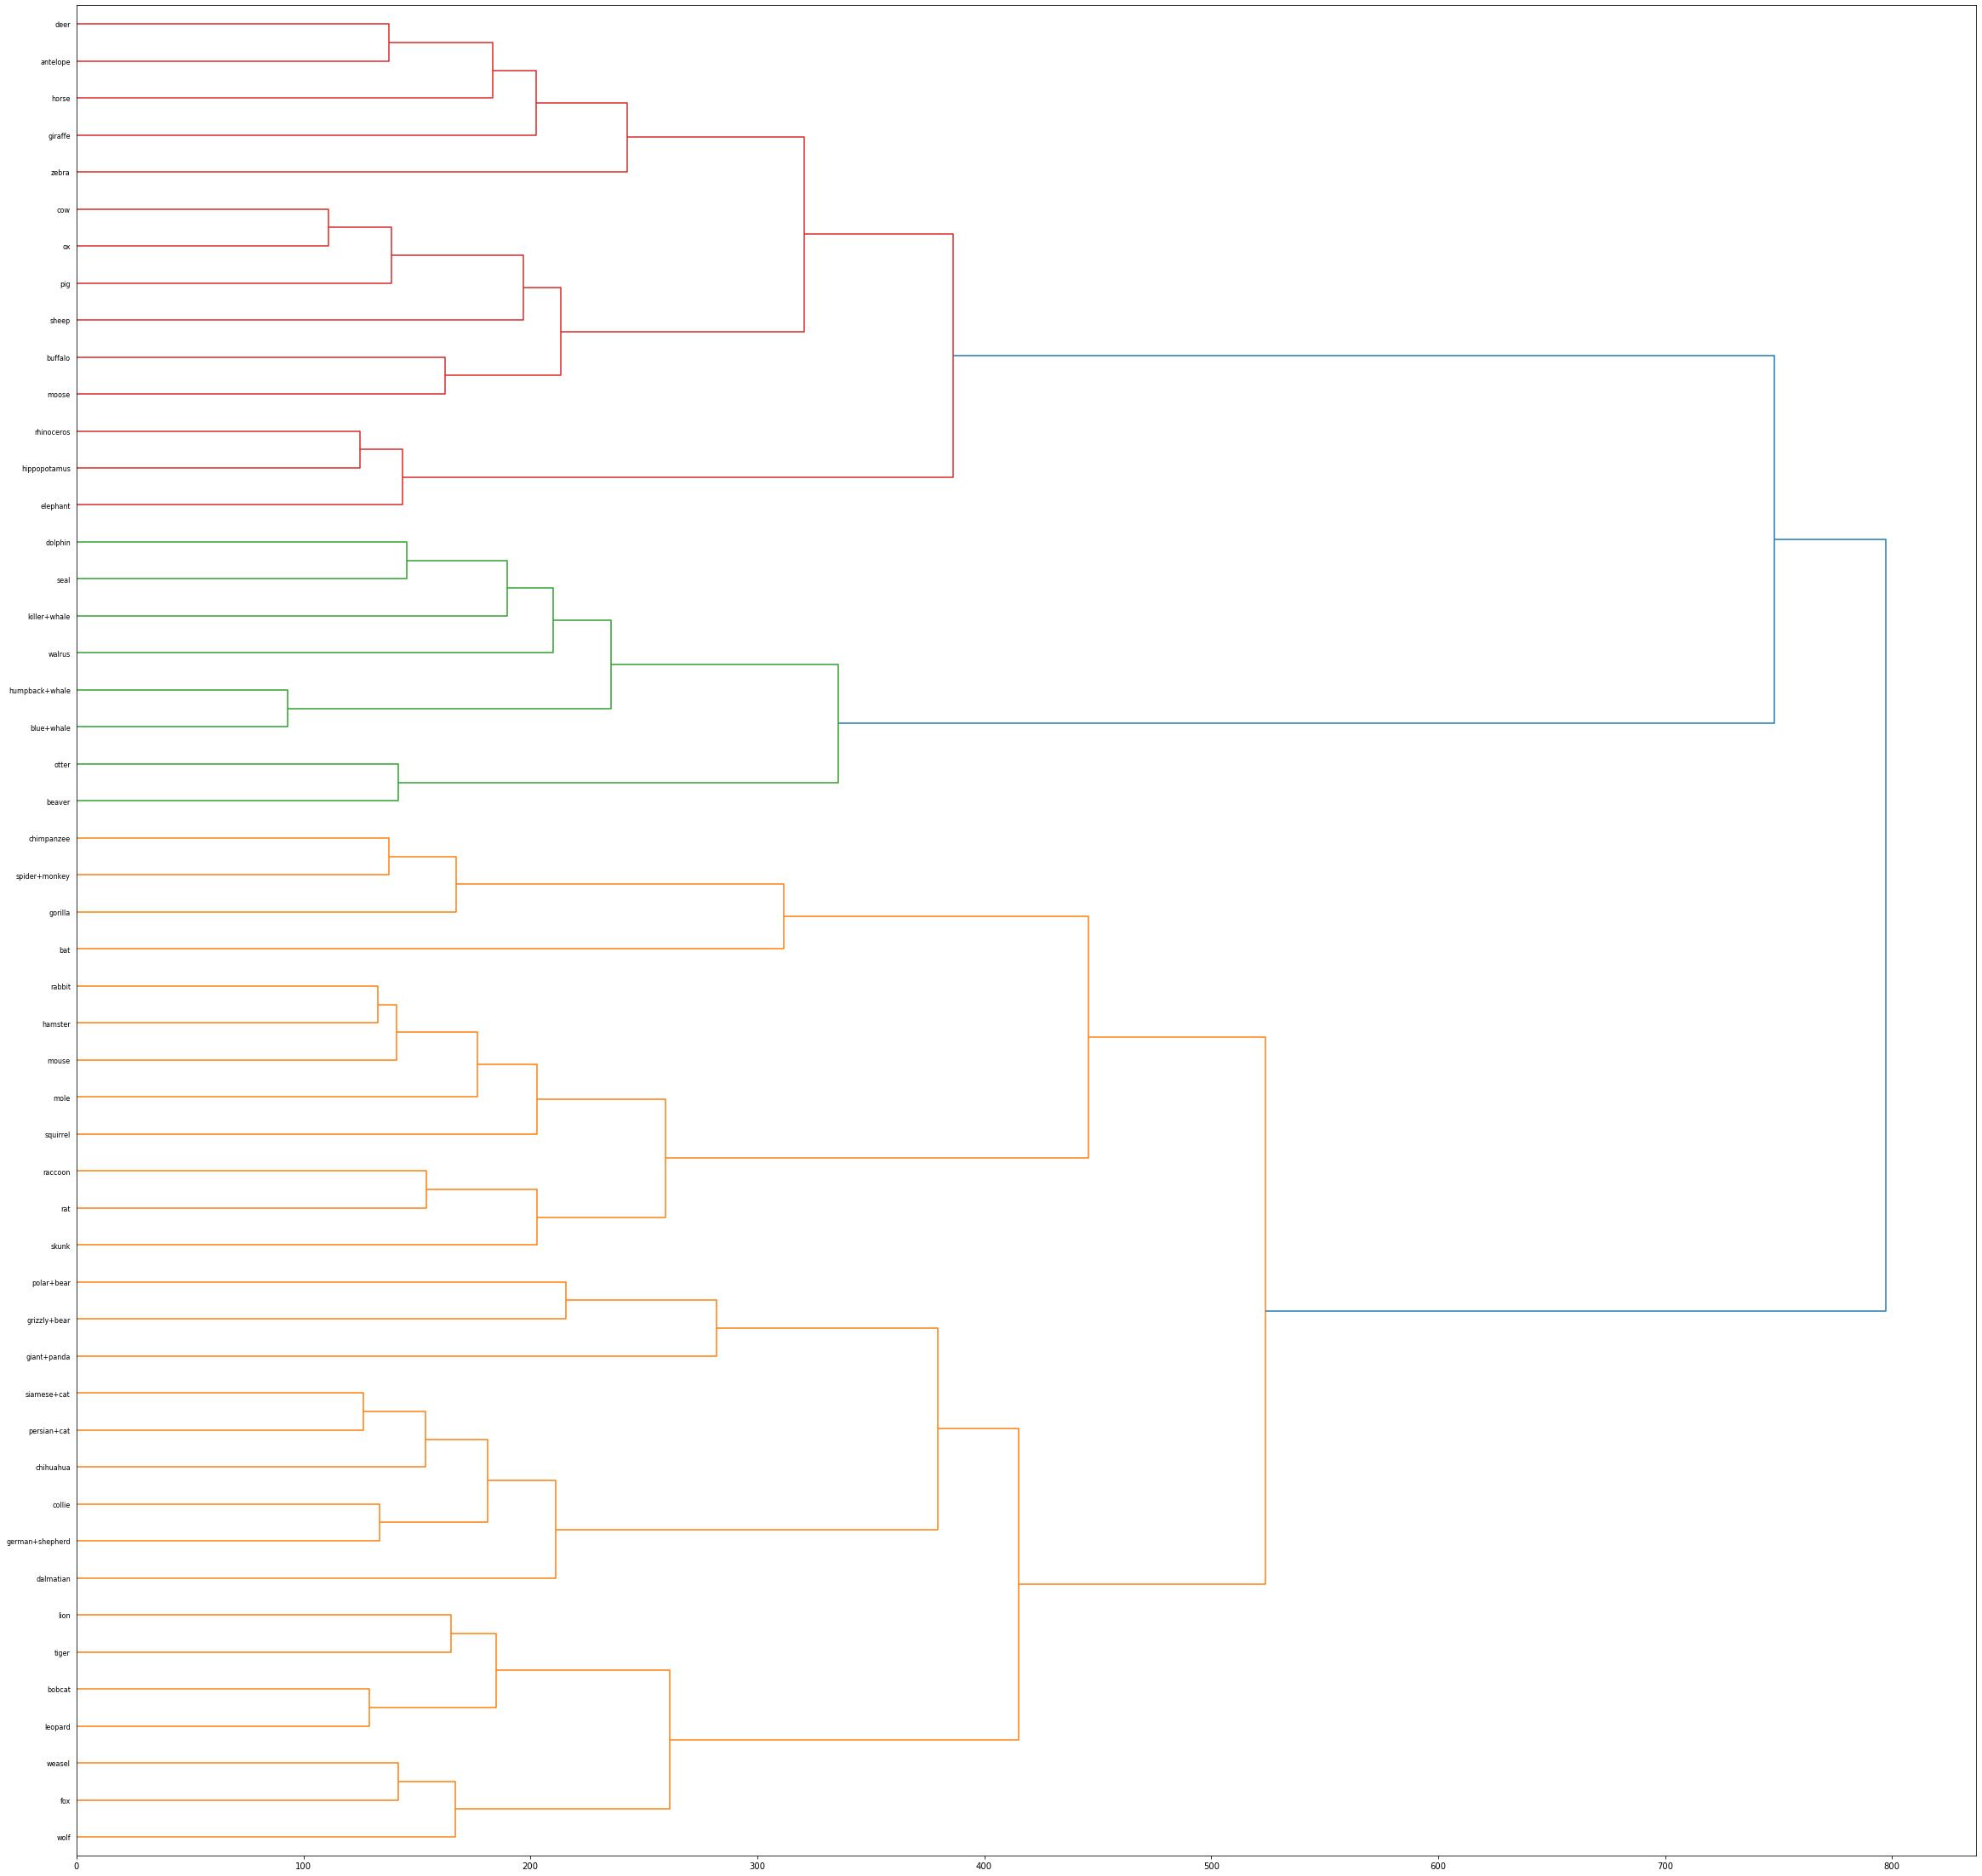

In [40]:
# use scipy.cluster.hierarchy.linkage to hierarchically cluster this data.
hierarchically_cluster_link = linkage(predicate_matrix, method = 'ward');

# use dendrogram method to plot the resulting tree.
dendrogram(hierarchically_cluster_link, orientation = "right", labels = classes_with_animal_names)

# resize the figure
rcParams['figure.figsize'] = [40,40]

### Conclusion for (b):

#### Does the hierarchical clustering seem sensible to you?
#### --- Yes, it seems sensible to me.
#### --- For choosing the linkage, Ward’s method is the sensible default. It groups based on reducing the sum of squared distances of each observation from the average observation in a cluster.

#### (c) Turn in an iPython notebook with a transcript of all this experimentation.

#### See above for all this experimentation